Reading image.out
Total flux = 3.038954645170862e-14 Janskys


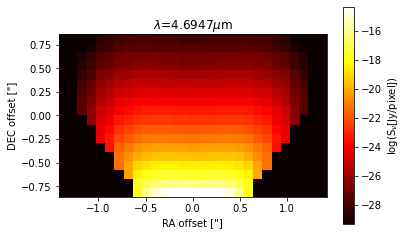

In [98]:
import matplotlib
from radmc3dPy.image import *
import matplotlib.pyplot as plt
from matplotlib import cm

distance = 140 #pc

fig1=plt.figure()
plt.ioff()

img = readImage() 

im_nx, im_ny = img.nx, img.ny # number of pixels on each axis
pixsize_x, pixsize_y = img.sizepix_x, img.sizepix_y # pixel sizes in cm (radians?)
dA = (pixsize_x * pixsize_y)/((distance*3.086e18)**2) # size of each pixel in steradians

image_data = img.image.flatten()
total_flux = np.sum(image_data)*dA*1e23 #summed intensity converted to flux in Jy    
    
print("Total flux =",total_flux,"Janskys")

result = plotImage(img, log=True, maxlog=15,fig=fig1, cmap=cm.hot, bunit='snu', dpc=distance, arcsec=True)

plt.savefig('output.png')
plt.close()

In [99]:
(pixsize_x/1.496E13)/(distance)

0.10147783251231526